<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/Copy_of_MATH0062_NB_2_2_Batch_normalisation_and_training_speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training speed of neural networks under different settings

In this notebook, we illustrate the effect of slow learning due to "vanishing gradient" and demonstrate how it can be potentially overcome by batch normalisation.

---



# The problem setup

This problem is taken from Problem Set 1 Question 4, which is a toy model of house price classification based on its location on a 2D map. You can simply consider the data as given, but feel free to look at NB 1.4 again to remind yourself the practical context in the background.


# The data

The block of code below generates and plots our data. It is exactly identical to the one in NB 1.4. Notice that we will not split them into training and validation sets because the main focus of this exercise is just to investigate the training performance rather than evaluating which model is the most appropriate.

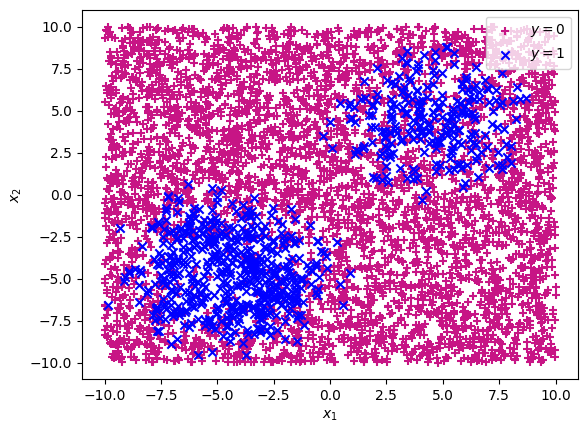

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

N = 5000 # number of observations

np.random.seed(0) # Fix random seed

# General the x,y features
obs_x1 = np.random.uniform(-10, 10, N)
obs_x2 = np.random.uniform(-10, 10, N)

# Convenient to combine the two individual features array into a matrix
obs_x = np.column_stack((obs_x1, obs_x2))

# Simulate the label values with noises based on some mysterious rule :)
obs_y = (((obs_x1+4.5)**2 + (obs_x2+4.5)**2 + np.random.normal(0,8,N) <= 12) + ((obs_x1-4.5)**2 + (obs_x2-4.5)**2 + np.random.normal(0,10, N) <= 5)).astype(int)

# Visualise the simulated data (don't worry too much about this block -  just some plotting tricks and they have nothing to do with deep learning)
cdict = {0: 'mediumvioletred', 1: 'blue'}
mark_all = {0: '+', 1: 'x'}
fig, ax = plt.subplots()
for g in np.unique(obs_y):
    ix = np.where(obs_y == g)
    ax.scatter(obs_x1[ix], obs_x2[ix], c = cdict[g], label = '$y=$' + str(g), marker = mark_all[g])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$ ')
ax.legend()

# Some functions to generate a generic neural network model

We are going to look at several different setups. We first define a function which will create a generic neural network with or without batch normalisation.

The user can supply the number of hidden layers, the number of neurons per layer, the activation function at hidden layers (the default choice is Sigmoid if unspecified), and whether batch normalisation is used at each hidden layer.

Note that the final activation function is always Sigmoid since we are working with a classification problem.

In [ ]:
# The code is slightly different from what we have seen previously above
# In particular, we write separate lines for "activation" and "batch normalisation"
def CreateModel(num_hidden_layer, num_neuron, act_fun = 'sigmoid', batch_norm = False):

    model = tf.keras.Sequential()

    # We don't apply batch normalisation if there is no hidden layer (in which case the FNN becomes a logistic regression model)
    if num_hidden_layer == 0:

        model.add(tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(2,)))
        return model

    else:

        # The first hidden layer
        model.add(tf.keras.layers.Dense(num_neuron, input_shape=(2,)))

        # Apply the batch normalisation layer if "batch_norm" is True
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())

        # Activation function for the first layer
        model.add(tf.keras.layers.Activation(act_fun))

        # Loop through construction of other hidden layers
        for i in range(num_hidden_layer - 1):

            model.add(tf.keras.layers.Dense(num_neuron))

            if batch_norm:
                model.add(tf.keras.layers.BatchNormalization())

            model.add(tf.keras.layers.Activation(act_fun))

        # The output layer
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        return model

# Cases to be considered in our study

We are going to compare four different settings. The baseline model is a feedforward neural network with 10 hidden layers (so it is quite "deep"), 8 neurons per layer and Sigmoid activation functions at all hidden layers.

The cases to be considered are summarised as follows:

| Case | Batch Normalisation? | Optimiser |
| :-: | :-: | :-: |
| 1 |  No | Stochastic gradient descent |
| 2 |  No | RMSProp |
| 3 |  Yes | RMSProp |
| 4 | Yes | Adam |

We perform training under each of the above setting, and plot the training losses as well as the training accuracy (i.e. the proportion of correct classifications made on the training data by the trained model).

Epoch 1/25
79/79 [==============================] - 6s 11ms/step - loss: 0.5234 - accuracy: 0.8490
Epoch 2/25
79/79 [==============================] - 0s 6ms/step - loss: 0.4644 - accuracy: 0.8490
Epoch 3/25
79/79 [==============================] - 1s 9ms/step - loss: 0.4415 - accuracy: 0.8490
Epoch 4/25
79/79 [==============================] - 0s 6ms/step - loss: 0.4325 - accuracy: 0.8490
Epoch 5/25
79/79 [==============================] - 1s 8ms/step - loss: 0.4283 - accuracy: 0.8490
Epoch 6/25
79/79 [==============================] - 1s 9ms/step - loss: 0.4263 - accuracy: 0.8490
Epoch 7/25
79/79 [==============================] - 1s 7ms/step - loss: 0.4253 - accuracy: 0.8490
Epoch 8/25
79/79 [==============================] - 1s 9ms/step - loss: 0.4249 - accuracy: 0.8490
Epoch 9/25
79/79 [==============================] - 1s 9ms/step - loss: 0.4247 - accuracy: 0.8490
Epoch 10/25
79/79 [==============================] - 1s 9ms/step - loss: 0.4246 - accuracy: 0.8490
Epoch 11/25
79/79 

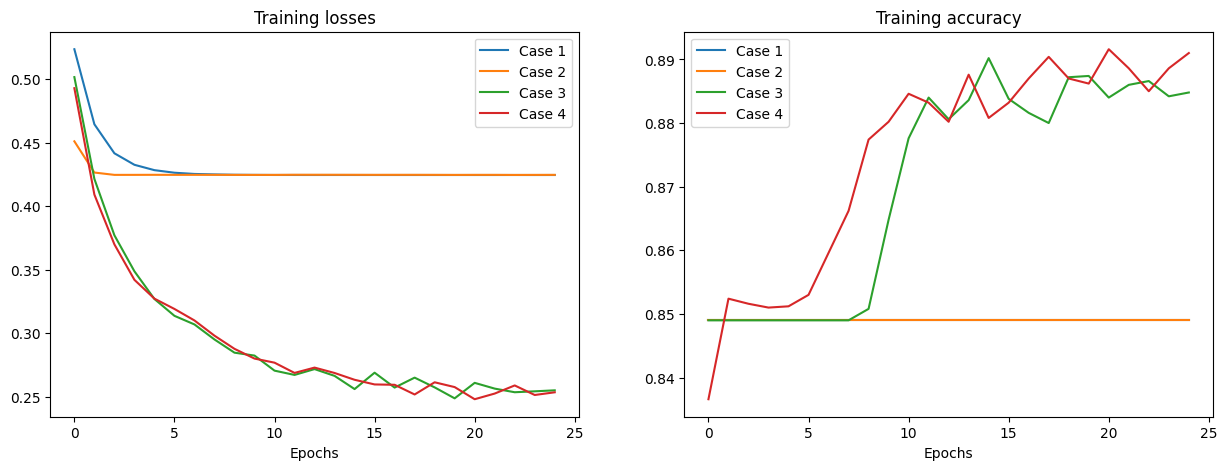

In [ ]:
# Structure of baseline model
num_hidden_layer = 10
num_neuron = 8

# Training parameters
num_epochs = 25
BatchSize = 64

ep = range(num_epochs)
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

# Loop over each case of interest
for i in range(4):

    if i == 0:

        model = CreateModel(num_hidden_layer, num_neuron, 'sigmoid', False)
        model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=['accuracy'])

    if i == 1:

        model = CreateModel(num_hidden_layer, num_neuron, 'sigmoid', False)
        model.compile(optimizer="RMSProp", loss="binary_crossentropy", metrics=['accuracy'])

    if i == 2:

        model = CreateModel(num_hidden_layer, num_neuron, 'sigmoid', True)
        model.compile(optimizer="RMSProp", loss="binary_crossentropy", metrics=['accuracy'])

    if i == 3:

        model = CreateModel(num_hidden_layer, num_neuron, 'sigmoid', True)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])


    # Train the model and collect the history of losses/accuracy
    result = model.fit(obs_x, obs_y, epochs=num_epochs, batch_size=BatchSize)
    train_loss = result.history['loss']
    train_acc = result.history['accuracy']

    # Plot the training losses and training accuracy
    ax1.plot(ep, train_loss, label= 'Case ' + str(i+1))
    ax1.set_title('Training losses')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    ax2.plot(ep, train_acc, label= 'Case ' + str(i+1))
    ax2.set_title('Training accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend()

Notice how the training losses in Case 1 and Case 2 become "saturated" after some number of epochs and beyond that the trainings are not "responsive" any more in the sense that the losses are not further reduced when we perform further iterations. It is precisely the problem of vanishing gradient since our activation functions are Sigmoid. However, when batch normalisation is used (in Case 3 and 4), the training "works" again.

